In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv

if not load_dotenv():
    raise FileNotFoundError("No .env file found")

In [3]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

gpt_4o = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [4]:
from llm_agents_introduction.alpha_vantage import AlphaVantageService

alpha_vantage = AlphaVantageService.create()

In [60]:
# Create a Tool definition without a tool to be used for routing
# Sub-agents can use this tool to return control to the supervisor agent
class ReturnToSupervisor(BaseModel):
    """
    Tool to return control to the supervisor agent.
    """

    reason: str

    class Config:
        schema_extra = {
            "example 1": {"reason": "The task is complete"},
            "example 2": {
                "reason": "I do not have the appropriate tools to complete the task"
            },
            "example 3": {
                "reason": "I have completed my portion of the task so the supervisor should review what happens next"
            },
        }

In [61]:
from llm_agents_introduction.tools.market_data_tools import create_market_data_tools

market_data_agent_system_prompt = """
You are a specialized agent can effectively use market data tools to find required data for a task provided by the supervisor agent or the user.
A supervisor agent will delegate to you when it needs to fetch market data.
When you have performed your task, use the ReturnToSupervisor tool to return control to the supervisor agent.
"""

market_data_tools = create_market_data_tools(alpha_vantage) + [ReturnToSupervisor]

market_data_agent_chain = (
    ChatPromptTemplate.from_messages(
        [
            ("system", market_data_agent_system_prompt),
            MessagesPlaceholder("messages"),
        ]
    )
    | gpt_4o.bind_tools(market_data_tools)
)


class ToMarketDataAgent(BaseModel):
    """
    Delegates a task to the Market Data agent.
    The Market Data agent can fetch market data using specialized tools for:
     - fetching company information
     - getting stock price or market capitalization for a date

    I do not support parallel function calls so put all of your tasks into a bulleted pointed list in the request parameter.
    """

    requests: str = Field(
        description="Bullet pointed list of tasks to perform",
    )

In [62]:
from llm_agents_introduction.tools.chart_tools import create_chart_tools

chart_agent_system_prompt = """
You are a specialized agent that can create charts of stock prices or market capitalization for a given stock symbol.
A supervisor agent will delegate to you when a chart is required.
When you have performed your task, use the ReturnToSupervisor tool to return control to the supervisor agent.
"""

chart_tools = create_chart_tools(alpha_vantage) + [ReturnToSupervisor]

chart_agent_chain = ChatPromptTemplate.from_messages(
    [
        ("system", chart_agent_system_prompt),
        MessagesPlaceholder("messages"),
    ]
) | gpt_4o.bind_tools(chart_tools, parallel_tool_calls=False)


class ToChartAgent(BaseModel):
    """
    Delegates a task to the Charting agent agent.
    The Chart agent can generate charts of stock prices or market capitalization for a given stock symbol and a particular date range.
    You should not fetch the market data from the MarketData agent as the Chart agent can do this for you.
    """

    requests: str = Field(
        description="Bullet pointed list of tasks to perform",
    )

In [63]:
from datetime import date

supervisor_agent_system_prompt = """
You are the primary agent in a system that can utilize multiple agents to answer questions about companies on the stock market.
You are responsible for delegating tasks to the appropriate agents and ensuring that the task is completed.
These agents refer to you as the Supervisor Agent.
Delegate tasks to these agents by invoking the corresponding tool.
When the task is complete, or you cannot complete the task - respond to the user.

The user is not aware of there being multiple agents and will only interact with you. Do not mention these sub-agents by name to the user.

The current date is: {current_date}
"""

supervisor_tools = [ToMarketDataAgent, ToChartAgent]


supervisor_agent_chain = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_agent_system_prompt),
        MessagesPlaceholder("messages"),
    ]
).partial(current_date=date.today().isoformat) | gpt_4o.bind_tools(
    supervisor_tools, parallel_tool_calls=False
)

In [64]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, END
import operator


class State(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]

In [65]:
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint import MemorySaver
from langchain_core.messages import ToolMessage, AIMessage, ToolCall


def supervisor_agent_node(state: State):
    response = supervisor_agent_chain.invoke(state)
    return {
        "messages": [response],
    }


def market_data_agent_node(state: State):
    response = market_data_agent_chain.invoke(state)
    return {
        "messages": [response],
    }


def chart_agent_node(state: State):
    response = chart_agent_chain.invoke(state)
    return {
        "messages": [response],
    }


def to_specialized_agent_node(state: State):
    last_tool_call: ToolCall = state["messages"][-1].tool_calls[0]
    tool_name: str = last_tool_call["name"]
    agent_name = tool_name.removeprefix("To").removesuffix("Agent")

    return {
        "messages": [
            ToolMessage(
                tool_call_id=last_tool_call["id"],
                content=f"The assistant is now the {agent_name} agent. "
                + "Reflect on the conversation and use your tools to attempt to answer the latest task.\n"
                + "If you have completed the task, do not have the right tools to complete the task, or simply don't know what to do "
                + "use the ReturnToSupervisor tool to return control to the supervisor agent.\n"
                + "Do not mention who are you - just act as a proxy for the supervisor agent.",
            )
        ]
    }


def return_to_supervisor_node(state: State):
    last_tool_calls = state["messages"][-1].tool_calls
    last_tool_call = last_tool_calls[0] if last_tool_calls else None

    return (
        {
            "messages": [
                ToolMessage(
                    tool_call_id=last_tool_call["id"],
                    content="Returning control to the supervisor agent. Reflect on the past conversation for how to continue.",
                )
            ]
        }
        if last_tool_call
        else {"messages": []}
    )


graph = StateGraph(State)


graph.add_node("supervisor_agent", supervisor_agent_node)
graph.add_node("market_data_agent", market_data_agent_node)
graph.add_node("chart_agent", chart_agent_node)
graph.add_node(ToolNode(market_data_tools, name="market_data_tools"))
graph.add_node(ToolNode(chart_tools, name="chart_tools"))
graph.add_node("to_specialized_agent", to_specialized_agent_node)
graph.add_node("return_to_supervisor", return_to_supervisor_node)


def route_supervisor_agent(state: State):
    last_message: AIMessage = state["messages"][-1]

    return "to_specialized_agent" if last_message.tool_calls else END


def to_specialized_agent_router(state: State):
    last_message: AIMessage = state["messages"][-2]
    tool_name = last_message.tool_calls[0]["name"] if last_message.tool_calls else None

    if tool_name == ToMarketDataAgent.__name__:
        return "market_data_agent"
    elif tool_name == ToChartAgent.__name__:
        return "chart_agent"
    else:
        return END


def create_specialized_agent_router(tool_node_name: str):
    def specialized_agent_router(state: State):
        last_message: AIMessage = state["messages"][-1]
        tool_name = (
            last_message.tool_calls[0]["name"] if last_message.tool_calls else None
        )

        if tool_name == ReturnToSupervisor.__name__:
            return "return_to_supervisor"
        elif tool_name:
            return tool_node_name
        else:
            return "return_to_supervisor"

    return specialized_agent_router


graph.set_entry_point("supervisor_agent")

graph.add_conditional_edges(
    "supervisor_agent",
    route_supervisor_agent,
    {
        "to_specialized_agent": "to_specialized_agent",
        END: END,
    },
)
graph.add_conditional_edges(
    "to_specialized_agent",
    to_specialized_agent_router,
    {"chart_agent": "chart_agent", "market_data_agent": "market_data_agent"},
)
graph.add_conditional_edges(
    "market_data_agent",
    create_specialized_agent_router("market_data_tools"),
    {
        "return_to_supervisor": "return_to_supervisor",
        "market_data_tools": "market_data_tools",
    },
)
graph.add_conditional_edges(
    "chart_agent",
    create_specialized_agent_router("chart_tools"),
    {
        "return_to_supervisor": "return_to_supervisor",
        "chart_tools": "chart_tools",
    },
)

graph.add_edge("chart_tools", "chart_agent")
graph.add_edge("market_data_tools", "market_data_agent")
graph.add_edge("return_to_supervisor", "supervisor_agent")

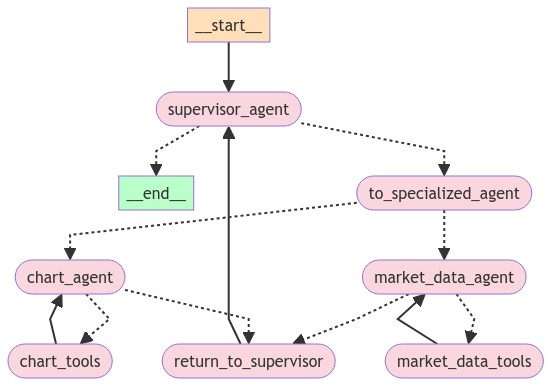

In [66]:
from IPython.display import Image, display, Markdown

checkpointer = MemorySaver()

app = graph.compile(checkpointer)
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [67]:
from langchain_core.messages import HumanMessage

state = {
    "messages": [
        HumanMessage(
            "Between Microsoft, Google and Apple - which company has increased the most in market cap since 2020? Then plot that company's market cap on a graph."
        ),
    ]
}
config = {"configurable": {"thread_id": "test2"}, "recursion_limit": 100}

for event in app.stream(state, config=config, stream_mode="updates"):
    node_key = next(iter(event.keys()), None)
    if not node_key:
        continue

    node_update = event[node_key]
    messages = node_update.get("messages", [])

    latest_message = messages[-1] if messages else None

    if isinstance(latest_message, AIMessage) and latest_message.content:
        display(Markdown(latest_message.content))

Here are the market capitalizations for Microsoft, Google, and Apple on January 1, 2020, and October 1, 2023:

- **Microsoft (MSFT)**
  - January 1, 2020: $1,172,075,287,000
  - October 1, 2023: $2,346,751,882,500
  - Increase: $1,174,676,595,500

- **Google (GOOGL)**
  - January 1, 2020: $393,378,843,000
  - October 1, 2023: $768,671,640,000
  - Increase: $375,292,797,000

- **Apple (AAPL)**
  - January 1, 2020: $1,125,714,616,250
  - October 1, 2023: $2,625,351,261,000
  - Increase: $1,499,636,644,750

Apple has had the largest increase in market capitalization since 2020.

I will now plot Apple's market cap on a graph.

Apple has had the largest increase in market capitalization since 2020. Here is the market capitalization chart for Apple (AAPL) from January 1, 2020, to October 1, 2023:

![Apple Market Cap](https://genai-agents-intro.s3.amazonaws.com/0be75038-8fc3-4807-bf7e-e9a5906177f3.png)